<a href="https://colab.research.google.com/github/andreasfloros/ARM-ML-Embedded/blob/main/audio_classifier_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classifier pipeline

### 1) Download and untar dataset directly to colab:

To change between datasets change the url to one which downloads a .tar file.

**Other important notes:**

**1.** If the audio_data folder already exists in your collab session running the following cell will give an error. That is not a problem, run it anyway.

**2.** To load the audio samples we use the librosa library. Its load function supports a large range of input formats such as WAV, MP3, FLAC, OGG and many others. For the full list of available input formats please refer to the documentation at https://librosa.org/doc/main/generated/librosa.load.html. An important point is that the library can't load README files, which can often be found in datasets as .md and .txt files. Not deleting such files will cause the library  to fail when processing the dataset!

In [1]:
import os
import requests
import tarfile

DATASET_ROOT_DIR = 'audio_data/'
os.mkdir(DATASET_ROOT_DIR)
url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
target_path = 'audio_data/dataset.tar.gz'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

tar = tarfile.open(target_path, "r:gz")
tar.extractall(path='audio_data/')
tar.close()

### 2) Preprocess dataset:

We iterate through the entire dataset, process every audio track using a processing method (either FFT, STFT, or MFCC), and store all of them in a JSON file. Currently, the user is able to control the processing method, expected duration of the audio tracks, the sample rate, as well as other values related to the processing methods.

Potentially, the user might also be able (in the future) to automatically go through all processing methods and use the one which optimizes the current model accuracy.

The process explained above can be completed through the following steps.

**Step 1:** Import necessary libraries

In [18]:
import os
import librosa
import math
import json
import numpy as np

**Step 2:** Function to extend/cut tracks appropriately so that all contain the expected number of samples

In [3]:
def make_track_correct_size(signal, expected_num_samples_per_track):

    # print('Original track length: {}'.format(len(signal)))
    # if track is shorter than expected, append it with zeros
    if len(signal) < expected_num_samples_per_track:
      num_zeros_to_pad = expected_num_samples_per_track - len(signal)
      zeros = num_zeros_to_pad * [0.]
      extended_signal = np.append(signal, zeros)
      return extended_signal

    # if track is longer than expected, truncate it
    elif len(signal) > expected_num_samples_per_track:
      return signal[:expected_num_samples_per_track]

    # else return the original track 
    else:
      return signal

**Step 3:** Define function to process a single track using the specified method (FFT/STFT/MFCC) and return the data structure containing the result. This function will be called for all tracks within the dataset. Also note that we always return a 1D array by flattening the 2D arrays where necessary. We do this so that we can replicate the exact same preprocessing on Arduino.

In [31]:
def audio_track_to_features(signal, processing_method, sample_rate, window_size, window_stride, num_mfcc):
  
  if processing_method == 'fft':
    # perform Fast Fourier Transform (FFT)
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # the spectrum is symmetrical with respect to sample_rate / 2
    # so take half of the spectrum and frequency arrays
    # therefore len(half_spectrum) = sample_rate / 2
    half_spectrum = spectrum[:int(len(spectrum)/2)]

    # average every 16 samples to reduce size of array to 1 / 16 of its original size
    # e.g. sample_rate = 16k, duration = 1.024s, reduce size from 8192 to 512 
    averaged = np.mean(half_spectrum.reshape(-1, 16), axis=1)

    # transform to range -128 to 127
    averaged *= (255.0/averaged.max()) # 0-255
    averaged -= 128

    return averaged


  elif processing_method == 'stft':
    # perform Short Time Fourier Transform (STFT)
    stft = librosa.stft(signal = signal, 
                        n_fft = window_size, 
                        hop_length = window_stride)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)

    # transpose and return the spectrogram matrix
    transposed_spectrogram = spectrogram.transpose()
    return transposed_spectrogram.flatten()


  else: # mfcc
    # perform Mel-Frequency Cepstral Coefficients (MFCC)
    mfcc = librosa.feature.mfcc(signal, 
                                sr = sample_rate, 
                                n_fft = window_size, 
                                n_mfcc = num_mfcc,
                                hop_length = window_stride)
    # transpose and return the mfcc matrix
    transposed_mfcc = mfcc.T
    return transposed_mfcc.flatten()

**Step 4:** Define function to process every audio track and create a JSON file with the entire processed dataset

In [32]:
def preprocess_entire_dataset(dataset_path, json_path, processing_method, sample_rate, expected_duration, window_size, window_stride, num_mfcc):
  # expected duration is in seconds
  expected_num_samples_per_track = int(expected_duration * sample_rate)
  
  # dictionary to later be converted to final json file
  data = {
      'mapping' : [],
      'features' : [],
      'labels' : []
  }

  # we will iterate this for each of the visited sub-directorie in order to
  # give a different label for each of them
  visited_directory_index = 0

  # iterate through all subfolders
  for dirpath, dirnames, filenames in os.walk(dataset_path):

    # # ensure we are not at the dataset root directory
    # # (os.walk provides this directory as well)
    # if dirpath is not DATASET_ROOT_DIR:
    if dirpath == 'audio_data/yes' or dirpath == 'audio_data/no':

      # obtain word labels
      dirpath_components = dirpath.split('/') # audio_data/left => ['audio_data', 'left']
      word_label = dirpath_components[-1]
      data['mapping'].append(word_label)
      print('Processing {}'.format(word_label))

      # access and process files for current word
      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=sample_rate)

        # extend or cut signal to be equal to the expected size
        signal_correct_size = make_track_correct_size(signal, expected_num_samples_per_track)

        # obtain the features of the audio track using the function defined above
        track_features = audio_track_to_features(signal = signal_correct_size, 
                                                processing_method = processing_method,
                                                sample_rate = sample_rate, 
                                                window_size = window_size, 
                                                window_stride = window_stride, 
                                                num_mfcc = num_mfcc)
        
        # append the audio track features to the features field of the dictionary
        data['features'].append(track_features.tolist())

        # append the current directory index as the label of this track
        data['labels'].append(visited_directory_index)
        # print('file_path: {}'.format(file_path))

      # iterate the index before visiting the next directory
      visited_directory_index = visited_directory_index + 1

  print(data['mapping'])
  print(set(data['labels']))
  # create the json file from the dictionary
  with open(json_path, 'w') as fp:
    json.dump(data, fp, indent=4)

**Step 5:** Before running these functions with the code in the following cell we must delete the '.ipynb_checkpoint' files which might otherwise be considered as part of the dataset and interfere with training the model. We also delete the README.md file in the audio_data/background_noise directory.

In [33]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [34]:
!rm audio_data/_background_noise_/README.md

rm: cannot remove 'audio_data/_background_noise_/README.md': No such file or directory


**Step 6:** Run the preprocessing function above with the desired parameters

In [14]:
JSON_PATH = 'data.json'
PROCESSING_METHOD = 'fft'
SAMPLE_RATE = 16000
EXPECTED_DURATION = 1.024            # in seconds
WINDOW_SIZE_SAMPLES = 512            # in samples
WINDOW_STRIDE_SAMPLES = 320          # in samples
MFCC_COEFF_NUMBER = 13

preprocess_entire_dataset(dataset_path = DATASET_ROOT_DIR, 
                   json_path = JSON_PATH, 
                   processing_method = PROCESSING_METHOD,
                   sample_rate = SAMPLE_RATE, 
                   expected_duration = EXPECTED_DURATION, 
                   window_size = WINDOW_SIZE_SAMPLES, 
                   window_stride = WINDOW_STRIDE_SAMPLES, 
                   num_mfcc = MFCC_COEFF_NUMBER)

### 3) Build and evaluate model:

**Step 1:** Import necessary libraries

In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt

**Step 2:** Define functions to load and prepare the dataset for the model

In [9]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    print('Loading dataset')

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data['features'])
    y = np.array(data['labels'])
    return X, y


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    print('Splitting dataset into training, validation, and test splits')

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets for conv networks to fit conv2D shape specs
    # currently not needed since we reshape everything anyway
    # X_train = X_train[..., np.newaxis]
    # X_validation = X_validation[..., np.newaxis]
    # X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

**Step 3:** Define seperate functions for building a dense and a convolutional model

In [10]:
def build_conv_model(input_shape, reshape_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = Sequential()

    # reshape input from 1D to 2D
    model.add(Reshape(reshape_shape, input_shape=input_shape))

    # 1st conv layer
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv layer
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.3))

    # output layer
    model.add(Dense(2, activation='softmax'))

    return model

In [11]:
def build_dense_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = Sequential()

    model.add(Dense(16, activation='relu', input_shape=input_shape))
    # model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))

    # model.add(Dense(256, activation='relu'))
    # # model.add(Dropout(0.3))

    # model.add(Dense(512, activation='relu'))
    # # model.add(Dropout(0.3))

    # model.add(Dense(256, activation='relu'))

    # model.add(Dense(128, activation='relu'))
    # # model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))

    # output layer
    model.add(Dense(36, activation='softmax'))

    return model

**Step 4:** Define function to plot the training history of the model

In [12]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

**Step 5:** Run all of the above functions:

In [15]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
print('Finished preparing training, validation, and test data')
print('X_train.shape: {}'.format(X_train.shape))

Splitting dataset into training, validation, and test splits
Loading dataset
Finished preparing training, validation, and test data
X_train.shape: (4790, 512)


**Step 6:** Since when preprocessing the entire dataset we flattened all 2D arrays to 1D arrays, we calculate the original 2D dimentions in order to Reshape in the first layer of our Neural Network.

In [19]:
NUM_OF_SAMPLES = SAMPLE_RATE * EXPECTED_DURATION
NUM_OF_WINDOW_POSITIONS = math.ceil(NUM_OF_SAMPLES / WINDOW_STRIDE_SAMPLES)
NUM_OF_STFT_FREQUENCIES = int(1 + WINDOW_SIZE_SAMPLES / 2)

FFT_ARRAY_SIZE = int((NUM_OF_SAMPLES) / (2 * 16))  # 2 comes from half spectrum, 16 from averaging every 16 samples

if PROCESSING_METHOD == 'fft':
  RESHAPE_SHAPE = (1, FFT_ARRAY_SIZE, 1)
elif PROCESSING_METHOD == 'stft':
  RESHAPE_SHAPE = (NUM_OF_WINDOW_POSITIONS, NUM_OF_STFT_FREQUENCIES, 1)
else: # mfcc
  RESHAPE_SHAPE = (NUM_OF_WINDOW_POSITIONS, MFCC_COEFF_NUMBER, 1)

print(RESHAPE_SHAPE)

(1, 512, 1)


input_shape = (512,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 512, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 512, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 256, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 256, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 256, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 128, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None,

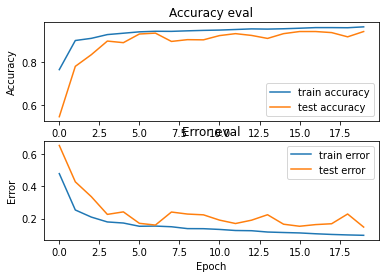

In [20]:
network_is_convolutional = True

# for convolutional model
if network_is_convolutional:
  input_shape = (X_train.shape[1],)
  print("input_shape = {}".format(input_shape))
  model = build_conv_model(input_shape, RESHAPE_SHAPE)
# for dense model
else:
  input_shape = (X_train.shape[1],)
  print("input_shape = {}".format(input_shape))
  model = build_dense_model(input_shape)


# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=20)

# plot accuracy/error for training and validation
plot_history(history)

**Step 7:** Define function to predict a single sample

In [21]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

63/63 - 1s - loss: 0.1371 - accuracy: 0.9434

Test accuracy: 0.943415105342865
Target: 0, Predicted label: [0]


### 4) Save model and convert to desired formats.

Save keras model as an .h5 file.

In [23]:
model_name = 'yesno_conv_fft_normalized'
model.save(model_name + '.h5')

For converting to tflite model there is a CHANCE that we require tensorflow 2.2 specifically. So check the version with the cell directly below and if the version isn't 2.2 (or 2.2.something) then run the cell below it. If it is please don't uninstall and reinstall the same version.

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [55]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.2

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 516.2MB 25kB/s 
     |████████████████████████████████| 460kB 43.0MB/s 
     |████████████████████████████████| 3.0MB 45.6MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1


Convert the model to a (currently not quantized due to commented out lines) tflite model.

In [24]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)


# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# def representative_dataset_generator():
#   for value in X_test:
#     yield [np.array(value, dtype = np.float32, ndmin=4)]

# converter.representative_dataset = representative_dataset_generator

tflite_model = converter.convert()

# Save the model to disk
open(model_name + '.tflite', "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize(model_name + '.tflite')
print("Model is %d bytes" % basic_model_size)

Model is 111236 bytes


Convert model from tflite file to byte array for deployment on Arduino.

In [25]:
!apt-get -qq install xxd
!xxd -i yesno_conv_fft_normalized.tflite > yesno_conv_fft_normalized.cc

Selecting previously unselected package xxd.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
